# Imports

In [1]:
import os
import torch
from tqdm import tqdm
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import gc

if not os.path.exists('data'):
    new_directory_path = "..\\..\\"
    os.chdir(new_directory_path)


from src.eval.eval_metrics import precision,recall,create_cls_targets, accuracy, eval_reg
from src.eval.eval_utils import plt_training_metrics, gather_best_metrics
from src.eval.vis_scanpath import draw_scanpath_mpl
from src.model.model_io import load_models_with_data
from src.training.training_utils import move_data_to_device, compute_loss


## Methods

In [2]:
def get_coords(idx, x,y, fixation_len, reg_out):
    if torch.all(x < 2):
        x = x.clone()
        x[:,:,0] = x[:,:,0] * 512
        x[:,:,1] = x[:,:,1] * 320
    x_coords = x[idx,:,:2].cpu().numpy().T
    y_coords = y[idx,:fixation_len[idx],:2].cpu().numpy().T
    reg_coords = reg_out[idx,:fixation_len[idx],:2].cpu().numpy().T
    x_coords = x_coords[:,::-1]
    y_coords = y_coords[:,::-1]
    reg_coords = reg_coords[:,::-1]
    return x_coords, y_coords, reg_coords

def batch_to_list(x, fixation_len = None):
    # convert from padded batch [B,T,F] to list of numpy arrays with shape [F,N]
    x_list = []
    for i in range(x.size(0)):
        l = 0
        if fixation_len is None:
            l = x.size(1)
        else:
            l = fixation_len[i]
        x_i = x[i,:l, :].cpu().numpy().T
        x_list.append(x_i)
    return x_list

def compute_classification_scores(cls_out,fixation_len):
    acum = np.zeros(7)
    count = np.zeros(7)
    all_count = 0
    for i in range(cls_out.shape[0]):
        cls_out_sample = cls_out[i]
        cls_out_sample = torch.sigmoid(cls_out_sample).cpu().numpy().T
        s = 3 - min(3, fixation_len[i])
        e = 3 + min(7,cls_out_sample.shape[1] - fixation_len[i])
        acum[s:e] += cls_out_sample[0,max(0,fixation_len[i]-3): fixation_len[i]+4 ]
        count[s:e] +=1
        all_count += 1
    avg = acum / count
    image_data = avg.reshape(7, 1).T
    count = (count/all_count).reshape(7, 1).T
    image_data = np.concat((image_data, count), axis=0)
    return image_data

def plot_scores(image_data, title, x_ticks, y_ticks):
    plt.figure(figsize= (image_data.shape[1] + 1, image_data.shape[0])) # Set the figure size to be tall and thin
    plt.imshow(image_data, cmap='gray', interpolation='nearest', aspect='auto')
    text_color = 'green' 
    for i in range(image_data.shape[0]):
        for j in range(image_data.shape[1]):
            score = image_data[i, j]
            
            plt.text(j, i, f'{score:.2f}', 
                        ha="center", va="center", color=text_color, fontsize=10)
    
    plt.title(title)
    xtick_coords, xtick_labels = x_ticks
    ytick_coords, ytick_labels = y_ticks
    
    plt.xticks(xtick_coords, xtick_labels) # Optional: keep y-axis labels for reference
    plt.yticks(ytick_coords, ytick_labels)
    
    plt.show()

def plot_classification_scores(image_data, title="Classification Scores"):
    plot_scores(image_data, title, 
                (range(7), [f'Token {i-3}' if i != 3 else 'END' for i in range(7)]),
                (range(2), ['score', 'sample per']))
    
def plot_reg_scores(image_data, title="Regression Scores"):
    plot_scores(image_data, title, 
                (range(image_data.shape[1]), [f'Token {i}' for i in range(image_data.shape[1])]),
                (range(3),['coords', 'dur', 'sample per']))
    
def invert_transforms(inputs, outputs, dataloader):
    pred_reg = outputs['reg']
    gt_reg = inputs['tgt']
    transforms = dataloader.path_dataset.transforms
    # reverse the transforms
    for transform in reversed(transforms):
        if transform.modify_y:
            pred_reg = transform.inverse(pred_reg)
            gt_reg = transform.inverse(gt_reg)
    outputs['reg'] = pred_reg
    inputs['tgt'] = gt_reg
    return inputs, outputs



In [3]:
import torch

B, H, W, F, L = 2, 16, 16, 64, 10
visual_tokens = torch.randn(B, H * W, F)
coords = torch.rand(B, L, 2)

coords = torch.floor(coords * 16).long()
visual_tokens = visual_tokens.view(B, H, W, F)

grid_h = coords[:, :, 0] 
grid_w = coords[:, :, 1]

batch_idx = torch.arange(B).unsqueeze(1).to(visual_tokens.device)

selected = visual_tokens[batch_idx, grid_h, grid_w]

print("Selected shape:", selected.shape) # Output: torch.Size([2, 10, 64])

Selected shape: torch.Size([2, 10, 64])


In [4]:
selected.shape

torch.Size([2, 10, 64])

# Eval

## Review Metrics

In [5]:


metric_path = ["metrics (1).json", "metrics (2).json"]

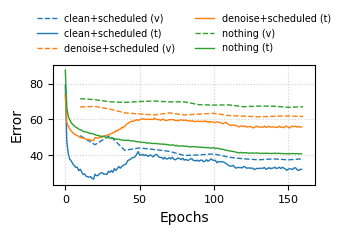

In [6]:
import json
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import cycle

# Standard LaTeX column width is ~3.5 inches
plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "figure.titlesize": 10
})

metric_folder = Path("training metrics")
colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Smaller figure size for a single column
fig, ax = plt.subplots(figsize=(3.5, 3.0))

for path in metric_folder.rglob('*.json'):
    if 'phase' in path.stem:
        continue
        
    with open(path, 'r') as f:
        data = json.load(f)
        reg_val = data.get('reg_error_val', [])
        reg_train = data.get('coord_error_train', [])

    if reg_val and reg_train:
        color = next(colors)
        
        # Validation line
        ax.plot([(i + 1) * 10 for i in range(len(reg_val))], 
                reg_val, '--', color=color, label=f'{path.stem} (v)', linewidth=1)
        
        # Training line
        ax.plot(reg_train, '-', color=color, label=f'{path.stem} (t)', linewidth=1)

ax.set_xlabel('Epochs')
ax.set_ylabel('Error')
ax.grid(True, linestyle=':', alpha=0.6)
# Place legend above the plot, spread into 2 columns to save height
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.50), 
    ncol=2, 
    fontsize='x-small', 
    frameon=False
)

plt.tight_layout()
plt.savefig("metrics_column.pdf", bbox_inches='tight') # PDF is best for LaTeX
plt.show()

## Checkout Output

### Eval Just One Batch

In [7]:
input_outputs = torch.load('inputs_outputs.pth', map_location='cpu')
print('>> All models:')
for model in input_outputs:
    print(model['model_name'])
    
to_test =[model['model_name'] for model in input_outputs if 'phase' not in model['model_name']]
input_outputs = [model for model in input_outputs if model['model_name'] in to_test]
print('>> Models to test:')
for model in input_outputs:
    print(model['model_name'])

>> All models:
phase + denoise + scheduled
phase + denoise
nothing
clean + Scheduler
denoise + scheduled
>> Models to test:
nothing
clean + Scheduler
denoise + scheduled


In [8]:
for model in input_outputs:
    print(model['model_name'])
    acum_cls_loss = 0
    acum_reg_loss = 0
    acum_coord_error = 0
    acum_duration_error = 0
    count = 0
    for i in range(len(model['inputs'])):
        input, output = model['inputs'][i], model['outputs'][i]
        cls_loss, reg_loss = compute_loss(input, output)
        reg_out, cls_out = output['reg'], output['cls']
        y, y_mask, fixation_len = input['tgt'], input['tgt_mask'], input['fixation_len']
        reg_error, dur_error = eval_reg(reg_out, y, y_mask)
        acum_cls_loss += cls_loss.item()
        acum_reg_loss += reg_loss.item()
        acum_coord_error += reg_error
        acum_duration_error += dur_error
        count += 1
    print(f'Cls Loss: {acum_cls_loss/count:.4f}, Reg Loss: {acum_reg_loss/count:.4f}')
    print(f'Regression error (pixels): {acum_coord_error/count:.4f}, Duration error ({acum_duration_error/count:.4f})')
    print('--------------------------------')

nothing
Cls Loss: 0.5947, Reg Loss: 8350.1186
Regression error (pixels): 66.9715, Duration error (93.9563)
--------------------------------
clean + Scheduler
Cls Loss: 0.3459, Reg Loss: 5770.7057
Regression error (pixels): 38.6638, Duration error (77.8665)
--------------------------------
denoise + scheduled
Cls Loss: 0.4288, Reg Loss: 7350.8477
Regression error (pixels): 61.9946, Duration error (87.5731)
--------------------------------


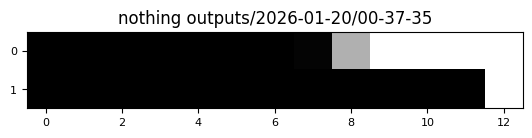

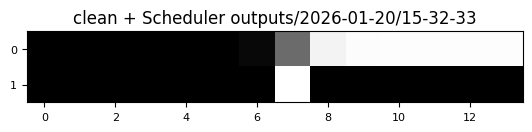

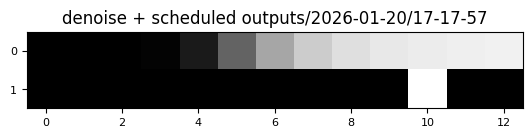

In [9]:
for i, model in enumerate(input_outputs):
    idx = randint(0,len(model['inputs']) - 1)
    reg_out, cls_out = model['outputs'][i]['reg'], model['outputs'][i]['cls']
    y, y_mask, fixation_len = model['inputs'][i]['tgt'], model['inputs'][i]['tgt_mask'], model['inputs'][i]['fixation_len']
    cls_out_sample = cls_out[idx]
    cls_out_sample = torch.sigmoid(cls_out_sample).cpu().numpy().T
    cls_targets = create_cls_targets(cls_out, fixation_len)
    cls_targets_sample = cls_targets[idx].cpu().numpy().T
    # vstack
    pair = np.vstack((cls_out_sample, cls_targets_sample)).T
    plt.imshow(pair.T, cmap='gray')
    plt.title(f'{model["model_name"]} {model["checkpoint_path"]}')
    plt.show()

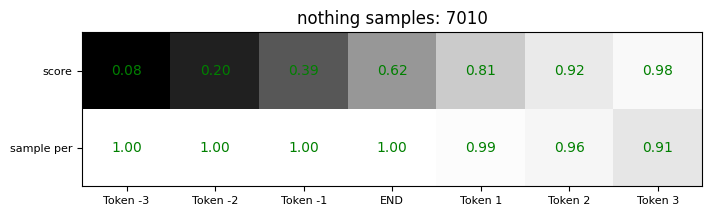

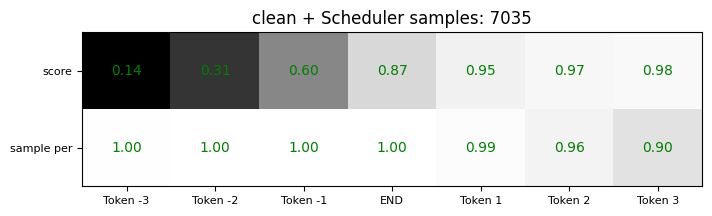

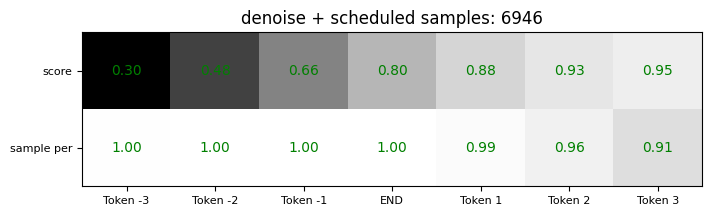

In [10]:

# put the value in each pixel
for  model in input_outputs:
    image_data_list = []
    count = 0
    for i in range(len(model['outputs'])):
        cls_out = model['outputs'][i]['cls']
        fixation_len = model['inputs'][i]['fixation_len']
        image_data = compute_classification_scores(cls_out, fixation_len)
        image_data_list.append(image_data)
        count += cls_out.shape[0]
    # Compute the mean image data across all samples, handling any potential NaNs for robustness
    image_data = np.nanmean(np.stack(image_data_list, axis=0), axis=0)
    plot_classification_scores(image_data, title=f"{model['model_name']} samples: {count}")

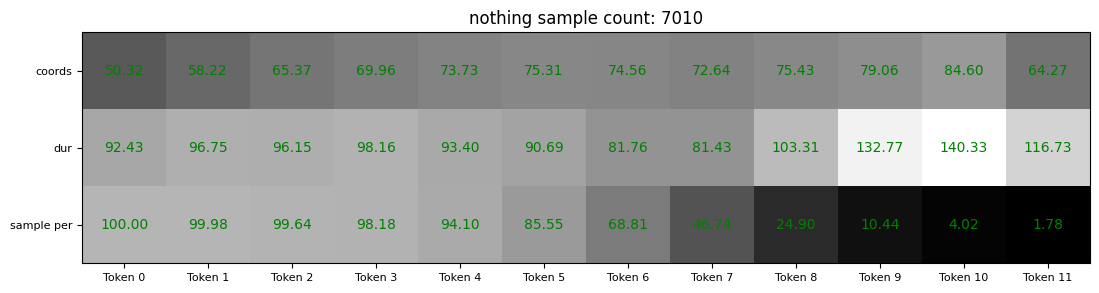

Skipped 9 samples


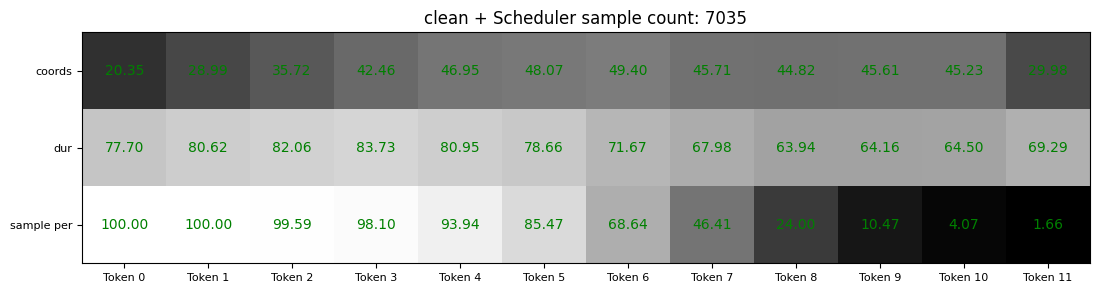

Skipped 13 samples


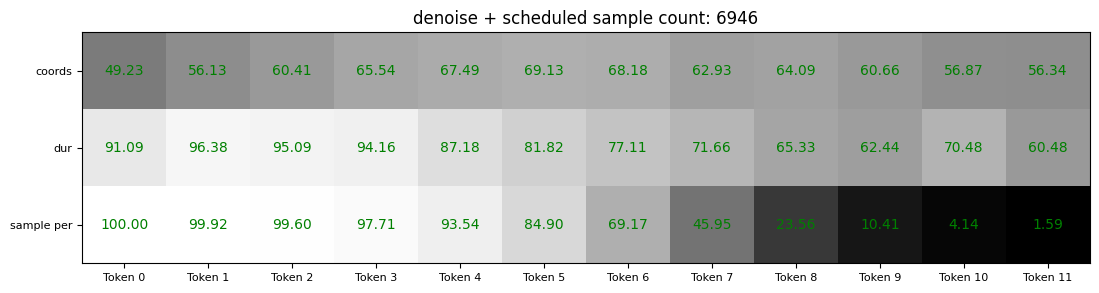

Skipped 8 samples


In [11]:
def error_distribution(reg, y, y_mask, remove_outliers = False):
    reg = reg.clone()
    y_mask = y_mask.unsqueeze(-1)[:,1:,:]
    count = y_mask.sum(dim = 0).squeeze().cpu().numpy()
    if remove_outliers:
        outliers = (reg[:,:-1,2:] > 1200) & y_mask
        reg[:,:-1,2:][outliers] = 1200
    diff = torch.where(y_mask, reg[:,:-1,:] - y, torch.tensor(0.0, device=y.device))
    diff_xy = diff[:,:,:2]
    reg_error = torch.sqrt(torch.sum(diff_xy**2, dim=-1))
    dur_error = torch.abs(diff[:,:,2])
    reg_error = reg_error.sum(dim = 0).cpu().numpy()
    dur_error = dur_error.sum(dim = 0).cpu().numpy()
    reg_error = (reg_error / count)[np.newaxis,:]
    dur_error = (dur_error / count)[np.newaxis,:]
    if remove_outliers:
        outliers_count = outliers.sum().item()
        return reg_error, dur_error, outliers_count
    else:
        return reg_error, dur_error

for model in input_outputs:
    image_data_list = []
    skipped_count = 0
    sample_count = 0
    for i in range(len(model['outputs'])):
        reg_out = model['outputs'][i]['reg']
        y, y_mask, fixation_len = model['inputs'][i]['tgt'], model['inputs'][i]['tgt_mask'], model['inputs'][i]['fixation_len']
        counts = y_mask[:,1:].sum(dim = 0)/y_mask.shape[0] * 100
        counts = counts.cpu().numpy()[np.newaxis, :]
        coord_error, dur_error, outliers_count = error_distribution(reg_out, y, y_mask, remove_outliers= True)
        image_data = np.concat((coord_error, dur_error, counts), axis=0)
        if image_data.shape[1] >= 12:
            image_data_list.append(image_data[:,:12])
        else:
            skipped_count += 1
        sample_count += reg_out.shape[0]
    image_data = np.nanmean(np.stack(image_data_list, axis=0), axis=0)
    plot_reg_scores(image_data, title=f"{model['model_name']} sample count: {sample_count}")
    print(f"Skipped {skipped_count} samples")
    
    

c:\Users\ulloa\OneDrive\Desktop\Practicas\projectes\Dataset\src\eval\vis_scanpath.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[-1], y[-1], s=marker_size, c=end_color, zorder=5)


Saved combined image to Output/scanpath_combined_model_denoise + scheduled.png


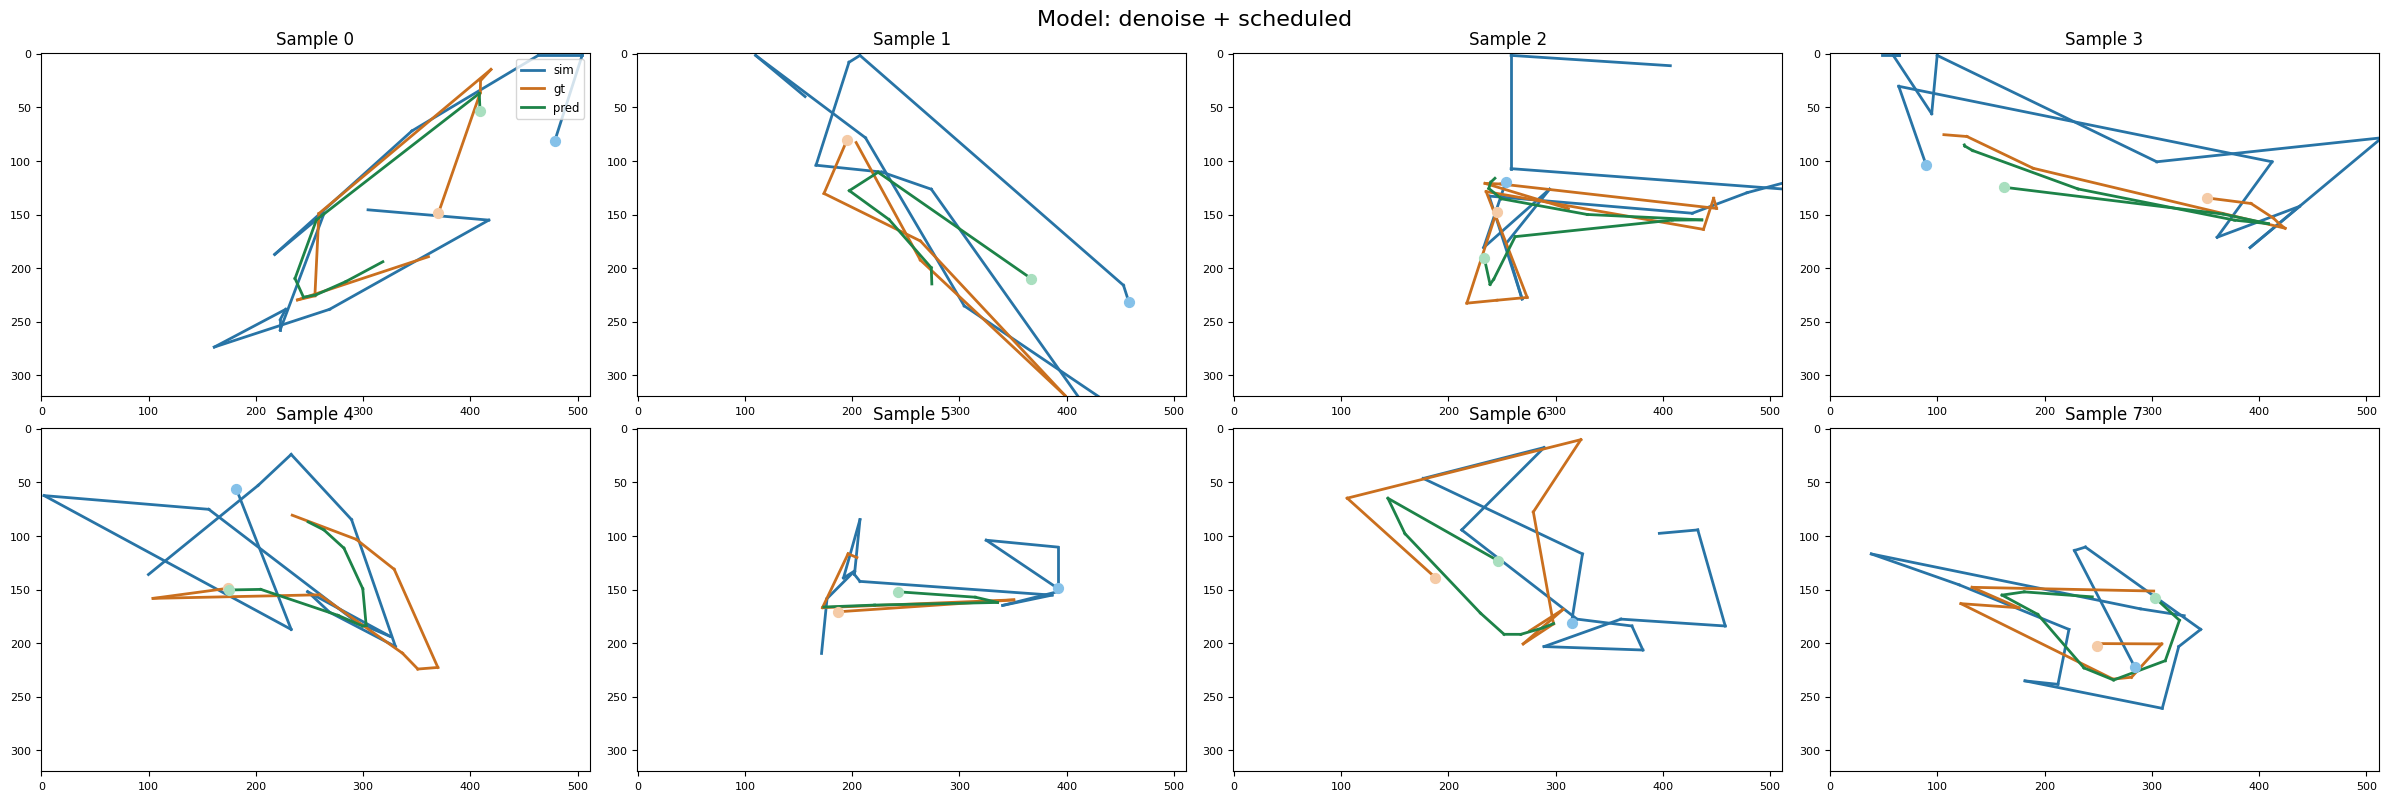

In [12]:
   
import matplotlib.pyplot as plt
import numpy as np
from random import randint

# Adjust figsize as needed. (24, 12) provides good resolution for a 2x4 grid.
FIG_SIZE = (24, 8) 

for model in input_outputs:
    if 'denoise' not in model['model_name']:
        continue

    # 1. Create the figure and a 2x4 array of axes BEFORE the loop
    fig, axes = plt.subplots(2, 4, figsize=FIG_SIZE)
    # Flatten the 2D array of axes into a 1D array to make iterating easier (0 to 7)
    axes_flat = axes.flatten() 

    for i in range(8):
        # Select the specific subplot axis for this iteration
        ax = axes_flat[i] 
        
        # --- Data Retrieval ---
        idx = randint(0, len(model['inputs']) - 1)
        reg_out, cls_out = model['outputs'][idx]['reg'], model['outputs'][idx]['cls']
        x, y, fixation_len = model['inputs'][idx]['src'], model['inputs'][idx]['tgt'], model['inputs'][idx]['fixation_len']
        
        # idx_2 was in your original code (assuming it's needed for get_coords logic or unused)
        idx_2 = randint(0, x.shape[0] - 1) 
        
        x_coords, y_coords, reg_coords = get_coords(idx, x, y, fixation_len, reg_out)
        img = np.ones((320, 512, 3), dtype=np.uint8) * 255

        labels = ['sim', 'gt', 'pred']

        trajs = [x_coords, y_coords, reg_coords]
        
        traj_colors = [
            (40/255, 116/255, 166/255),   # blue
            (202/255, 111/255, 30/255),   # orange
            (29/255, 131/255, 72/255)     # green
        ]

        end_point_colors = [
            (133/255, 193/255, 233/255),
            (245/255, 203/255, 167/255),
            (169/255, 223/255, 191/255)
        ]

        # --- Plotting on the specific axis (ax) ---
        for traj, color, end_color, lbl in zip(trajs, traj_colors, end_point_colors, labels):
            # Pass the specific 'ax' to your custom draw function
            ax = draw_scanpath_mpl(ax, traj[0], traj[1], color=color, end_color=end_color, label=lbl)

        # Use ax methods instead of plt methods
        ax.set_title(f'Sample {i}')
        ax.imshow(img)
        
        # Only add legend to the first subplot to avoid cluttering the grid
        if i == 0:
            ax.legend(loc='upper right', fontsize='small')
        
        # Optional: Hide axis ticks for cleaner look
        

    # --- Finalizing the combined figure ---
    plt.suptitle(f'Model: {model["model_name"]}', fontsize=16)
    plt.tight_layout()
    
    # Save the combined 2x4 image
    save_path = f'Output/scanpath_combined_model_{model["model_name"]}.png'
    plt.savefig(save_path)
    print(f"Saved combined image to {save_path}")
    
    plt.show()
    # Close the figure to free memory before the next model
    plt.close(fig)

In [13]:
def draw_scanpath_mpl(ax, x_coords, y_coords, color, end_color, label, scatter_size = 20, plot_index = True):
    """
    Plots a single scanpath trajectory with dashed lines and numbered fixations.
    """
    # 1. Plot the Trajectory Line (Thinner and Dashed)
    ax.plot(x_coords, y_coords, 
            color=color, 
            alpha=0.8, 
            linestyle='--',   # Dashed line
            linewidth=1.0,    # Thinner line (default is usually 1.5 or 2)
            label=label)

    # 2. Plot the Fixation Points (Dots)
    ax.scatter(x_coords, y_coords, color=color, s=scatter_size, alpha=0.8)
    
    # 3. Highlight the End Point
    if len(x_coords) > 0:
        ax.scatter(x_coords[-1], y_coords[-1], color=end_color, s=50, zorder=5, edgecolors='white')

    # 4. Add Numbers to Fixations
    # We zip x and y to get coordinates, and enumerate to get the number (0, 1, 2...)
    if plot_index:
        for i, (x, y) in enumerate(zip(x_coords, y_coords)):
            # Calculate a contrasting text color or use white
            # We add a small box around the text matching the line color for readability
            ax.text(x, y, str(i+1), 
                    color='white', 
                    fontsize=7, 
                    ha='center', va='center', 
                    fontweight='bold',
                    bbox=dict(boxstyle="circle,pad=0.2", fc=color, ec=color, alpha=0.7))

    return ax

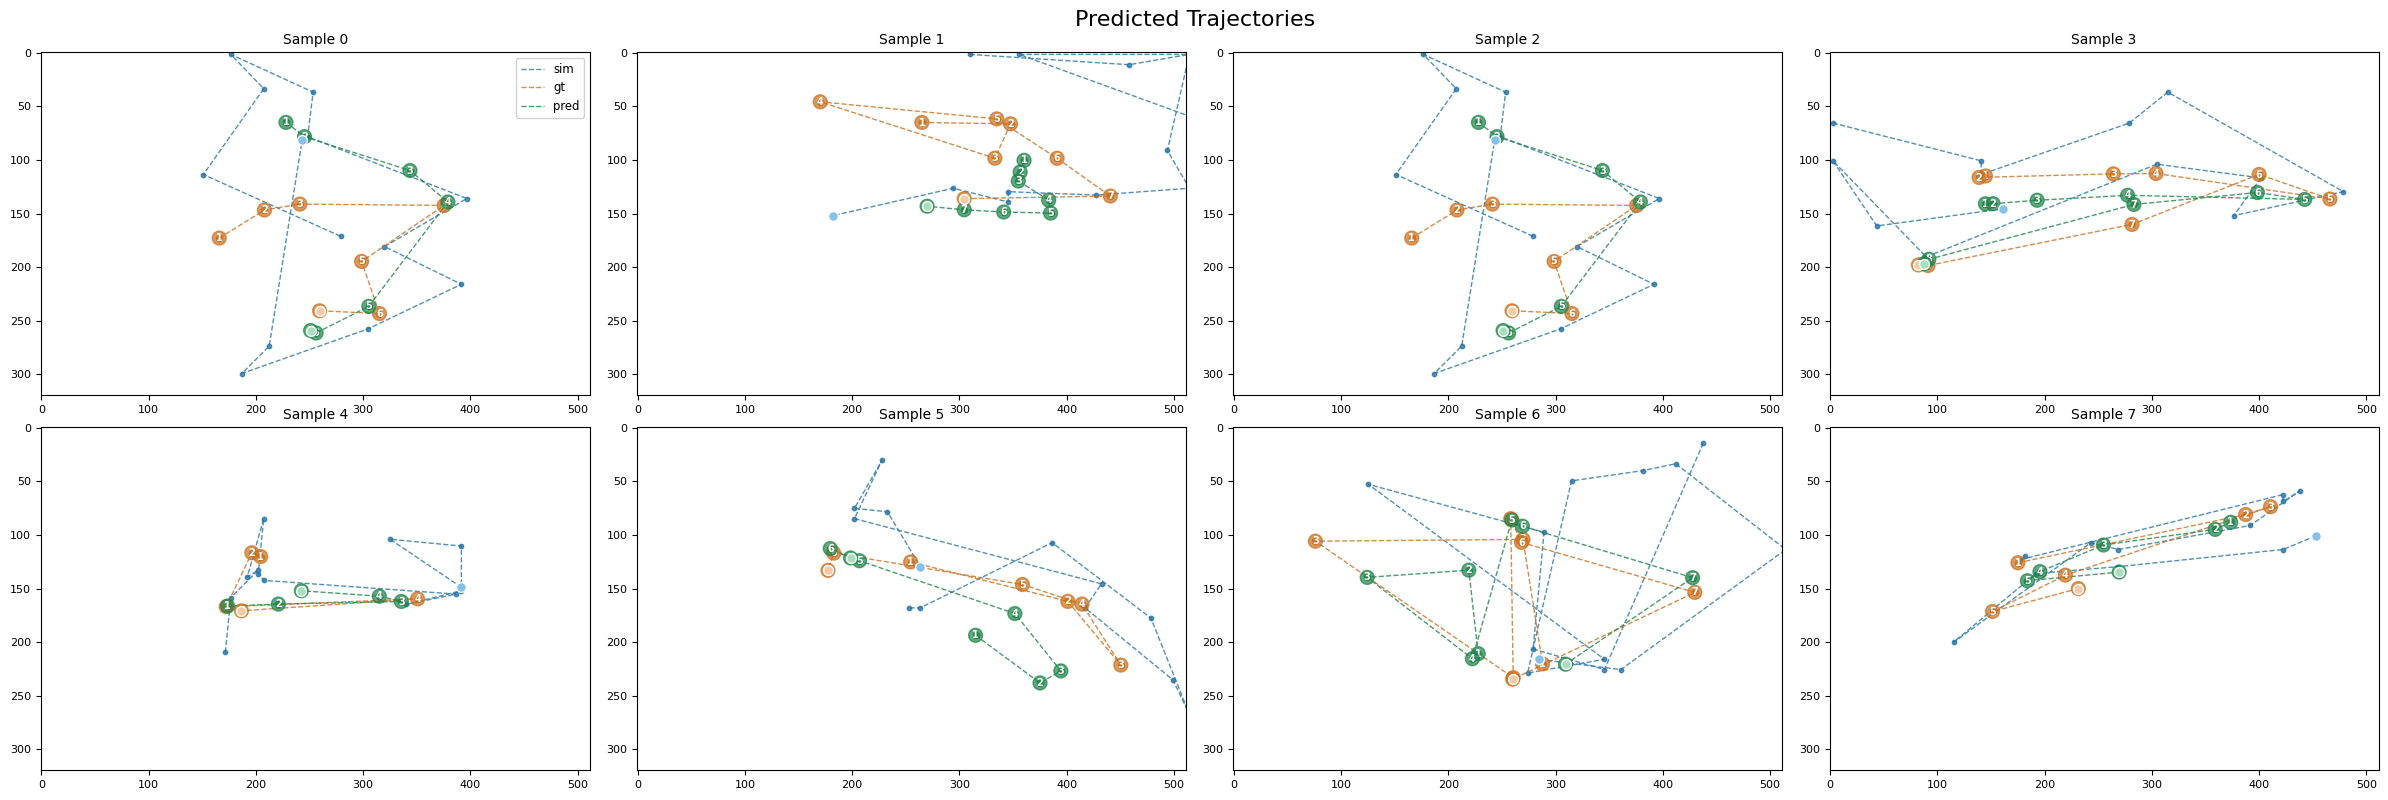

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint

# Setup for 2x4 grid
FIG_SIZE = (24, 8)

for model in input_outputs:
    if 'denoise' not in model['model_name']:
        continue

    # Initialize Grid
    fig, axes = plt.subplots(2, 4, figsize=FIG_SIZE)
    axes_flat = axes.flatten()

    for i in range(8):
        ax = axes_flat[i]
        
        # --- Data Retrieval ---
        idx = randint(0, len(model['inputs']) - 1)
        reg_out, cls_out = model['outputs'][idx]['reg'], model['outputs'][idx]['cls']
        x, y, fixation_len = model['inputs'][idx]['src'], model['inputs'][idx]['tgt'], model['inputs'][idx]['fixation_len']
        
        # Helper to get specific coordinates (Assuming this function exists in your env)
        idx_2 = randint(0, x.shape[0] - 1) 
        
        x_coords, y_coords, reg_coords = get_coords(idx, x, y, fixation_len, reg_out)

        
        # Background image
        img = np.ones((320, 512, 3), dtype=np.uint8) * 255

        # --- Plotting Configuration ---
        labels = ['sim', 'gt', 'pred']
        
        # Assuming each item here is a tuple/list like (x_array, y_array)
        trajs_data = [x_coords, y_coords, reg_coords]
        
        traj_colors = [
            (40/255, 116/255, 166/255),   # blue (Sim)
            (202/255, 111/255, 30/255),   # orange (GT)
            (29/255, 131/255, 72/255)     # green (Pred)
        ]

        end_point_colors = [
            (133/255, 193/255, 233/255),
            (245/255, 203/255, 167/255),
            (169/255, 223/255, 191/255)
        ]

        # --- Draw Loop ---
        for traj, color, end_color, lbl in zip(trajs_data, traj_colors, end_point_colors, labels):
            # We assume traj[0] is X coordinates and traj[1] is Y coordinates
            if lbl == 'sim':
                ax = draw_scanpath_mpl(ax, traj[0], traj[1], color=color, end_color=end_color, label=lbl, scatter_size=10, plot_index=False)
            else:
                ax = draw_scanpath_mpl(ax, traj[0], traj[1], color=color, end_color=end_color, label=lbl)

        # Subplot Formatting
        ax.set_title(f'Sample {i}', fontsize=10)
        ax.imshow(img)

        # Only put legend on the first subplot to save space
        if i == 0:
            ax.legend(loc='upper right', fontsize='small', framealpha=0.9)

    # --- Save and Close ---
    plt.suptitle(f'Predicted Trajectories', fontsize=16)
    plt.tight_layout()
    
    save_path = f'Output/qualitative_{model["model_name"]}.png'
    # plt.savefig(save_path, dpi=150) # Increased DPI for text readability
    plt.show()
    plt.close(fig)

### Load Stats


In [16]:
acc_list = []
reg_loss_list = []
cls_loss_list = []
pre_pos_list = []
rec_pos_list = []
pre_neg_list = []
rec_neg_list = []
outliers_list = []
coord_error_list = []
dur_error_list = []
all_model_x_list = []
all_model_y_list = []
all_model_reg_list = []
all_coordinate_error = []
all_duration_error = []
for model in input_outputs:
    acc_acum = 0
    cls_loss_acum = 0
    reg_loss_acum = 0
    pre_pos_acum = 0
    rec_pos_acum = 0
    pre_neg_acum = 0
    rec_neg_acum = 0
    coord_error_acum = 0
    duration_error_acum = 0
    outliers_accum = 0
    all_batch_reg_error = []
    all_batch_duration_error = []
    reg_results = []
    y_results = []
    x_results = []
    count = 0
    for i in range(len(model['inputs'])):
        input = model['inputs'][i]
        output = model['outputs'][i]
        cls_loss, reg_loss = compute_loss(input, output)
        
        y, y_mask, fixation_len = input['tgt'], input['tgt_mask'], input['fixation_len']
        x = input['src']
        reg_out, cls_out = output['reg'], output['cls']
        cls_loss_acum += cls_loss.item()
        reg_loss_acum += reg_loss.item()
        cls_targets = create_cls_targets(cls_out, fixation_len)
        acc_acum += accuracy(cls_out, y_mask, cls_targets)
        pre_pos_acum += precision(cls_out, y_mask, cls_targets)
        rec_pos_acum += recall(cls_out, y_mask, cls_targets)
        pre_neg_acum += precision(cls_out, y_mask, cls_targets, cls = 0)
        rec_neg_acum += recall(cls_out, y_mask, cls_targets, cls = 0)
        coord_error, dur_error = eval_reg(reg_out, y, y_mask)
        coord_error_acum += coord_error
        all_batch_reg_error.append(coord_error)
        duration_error_acum += dur_error
        all_batch_duration_error.append(dur_error)
        outliers_accum += outliers_count
        reg_results += batch_to_list(reg_out, fixation_len)
        y_results += batch_to_list(y, fixation_len)
        x_results += batch_to_list(x)
        count += 1
    all_coordinate_error.append(all_batch_reg_error)
    all_duration_error.append(all_batch_duration_error)
    outliers_list.append(outliers_accum)
    acc_list.append(acc_acum/count)
    reg_loss_list.append(reg_loss_acum/count)
    cls_loss_list.append(cls_loss_acum/count)
    pre_pos_list.append(pre_pos_acum/count)
    rec_pos_list.append(rec_pos_acum/count)
    pre_neg_list.append(pre_neg_acum/count)
    rec_neg_list.append(rec_neg_acum/count)
    coord_error_list.append(coord_error_acum/count)
    dur_error_list.append(duration_error_acum/count)
    all_model_x_list.append(x_results)
    all_model_y_list.append(y_results)
    all_model_reg_list.append(reg_results)

In [31]:
from src.eval.eval_metrics import eval_denoise

for model in input_outputs:
    print(list(model['outputs'][0].keys()))
    #if 'denoise' not in :
    #    continue
    continue
    all_denoise_list = []
    for i in range(len(model['inputs'])):
        input = model['inputs'][i]
        output = model['outputs'][i]
        y, y_mask, fixation_len = input['tgt'], input['tgt_mask'], input['fixation_len']
        x = input['src']
        clean_x = input['clean_x']
        denoise = output['denoise']
        value = eval_denoise(denoise, clean_x)
        all_denoise_list.append(value)
        count += 1
    print(sum(all_denoise_list)/count)

['reg', 'cls']
['reg', 'cls']
['reg', 'cls']


In [18]:

# plot evaluation metrics using pandas 
import pandas as pd
# Transpose the dataframe so models are columns and metrics are rows
# Swap the first and second model results
swapped_indices = list(range(len(input_outputs)))
if len(swapped_indices) >= 2:
    swapped_indices[0], swapped_indices[1] = swapped_indices[1], swapped_indices[0]

metrics_df = pd.DataFrame({
    'Reg_Loss': reg_loss_list,
    'Cls_Loss': cls_loss_list,
    'Accuracy': acc_list,
    'Precision_Pos': pre_pos_list,
    'Recall_Pos': rec_pos_list,
    'Precision_Neg': pre_neg_list,
    'Recall_Neg': rec_neg_list,
    'Coord_Error': coord_error_list,
    'Dur_Error': dur_error_list,
    'outliers Count': outliers_list
}, index=[f'{input_outputs[i]['model_name']}' for i in range(len(input_outputs))])
metrics_df = metrics_df.transpose()
metrics_df

,nothing,clean + Scheduler,denoise + scheduled
Reg_Loss,8350.118564,5770.705691,7350.847745
Cls_Loss,0.594699,0.345949,0.428791
Accuracy,0.872347,0.861164,0.783719
Precision_Pos,0.477713,0.463175,0.348418
Recall_Pos,0.627183,0.928374,0.906033
Precision_Neg,0.946906,0.988651,0.983467
Recall_Neg,0.905811,0.852011,0.766982
Coord_Error,66.971450,38.663823,61.994596
Dur_Error,93.956304,77.866484,87.573133
outliers Count,0.000000,0.000000,0.000000


In [19]:
import pandas as pd

def print_dataframe_as_latex(df, show_index=True, caption=None, label=None):
    """
    Prints the LaTeX code for a dataframe, including the index on the left.
    """
    try:
        latex_code = df.to_latex(
            index=show_index,       # Set to True to print the left-most index column
            index_names=True,       # Prints the name of the index column as a header
            caption=caption,
            label=label,
            escape=True,
            float_format="%.2f"
        )
        
        print("--- LaTeX Code Below ---\n")
        print(latex_code)
        print("------------------------")
        
    except AttributeError:
        print("Error: Ensure you are passing a valid pandas DataFrame.")

# --- Demo Usage ---

data = {
    'Method': ['Linear Regression', 'Random Forest', 'SVM', 'Neural Network'],
    'Accuracy': [0.8543, 0.9210, 0.8850, 0.9432],
    'F1 Score': [0.84, 0.91, 0.87, 0.94],
}

df = pd.DataFrame(data)

# STEP 1: Set the meaningful column as the index
# This moves 'Method' to the far left to act as the row header
df.set_index('Method', inplace=True)

# STEP 2: Print
print_dataframe_as_latex(
    metrics_df, 
    caption="Model Accuracy Results", 
    label="tab:accuracy"
)

--- LaTeX Code Below ---

\begin{table}
\caption{Model Accuracy Results}
\label{tab:accuracy}
\begin{tabular}{lrrr}
\toprule
 & nothing & clean + Scheduler & denoise + scheduled \\
\midrule
Reg\_Loss & 8350.12 & 5770.71 & 7350.85 \\
Cls\_Loss & 0.59 & 0.35 & 0.43 \\
Accuracy & 0.87 & 0.86 & 0.78 \\
Precision\_Pos & 0.48 & 0.46 & 0.35 \\
Recall\_Pos & 0.63 & 0.93 & 0.91 \\
Precision\_Neg & 0.95 & 0.99 & 0.98 \\
Recall\_Neg & 0.91 & 0.85 & 0.77 \\
Coord\_Error & 66.97 & 38.66 & 61.99 \\
Dur\_Error & 93.96 & 77.87 & 87.57 \\
outliers Count & 0.00 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}
\end{table}

------------------------


In [20]:
ori_x = []
for path in all_model_x_list[0]:
    path_clone = path.copy()
    path_clone[0] = path_clone[0]*512
    path_clone[1] = path_clone[1]*320
    ori_x.append(path_clone)

In [21]:
gaze_list = [(ori_x,'sim_noise',1/16), 
             (all_model_y_list[0],'gt',1/16),   
             *[(all_model_reg_list[i],f'{input_outputs[i]['model_name']}', 1/16) for i in range(len(all_model_reg_list))]]

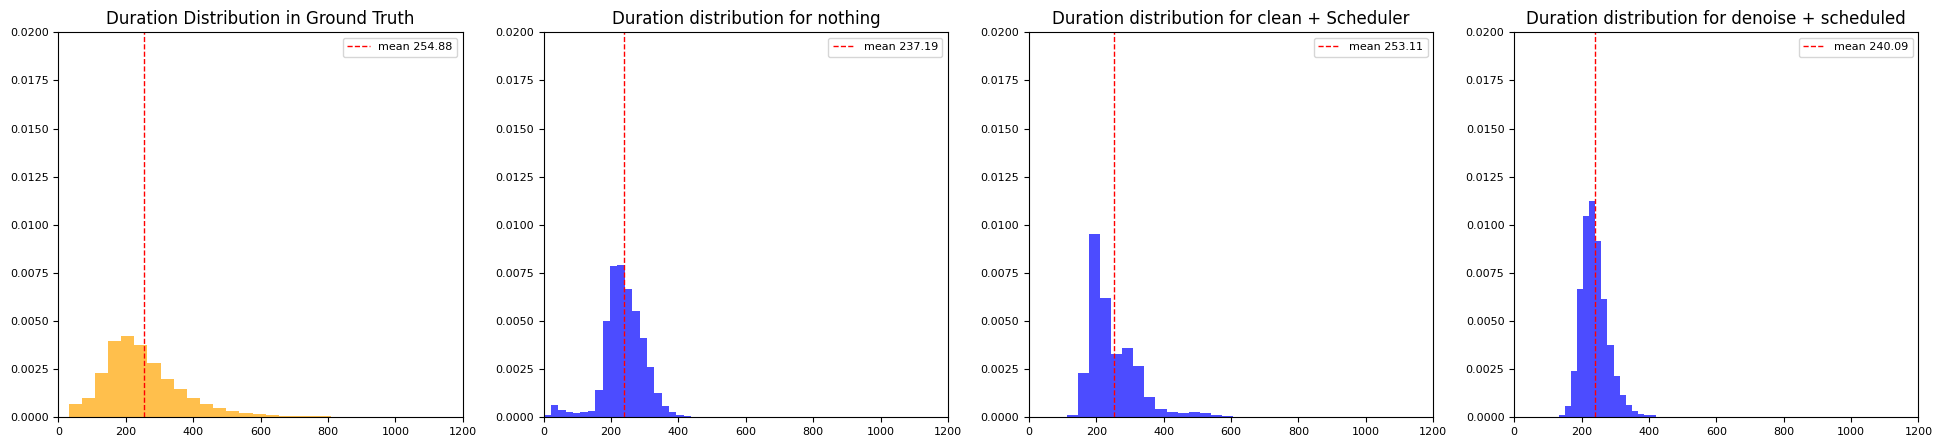

In [22]:
concatenated_y = np.concat([y[2] for y in all_model_y_list[0]])

# plot a hist of each array in two subplots
fig, axs = plt.subplots(1,1 + len(all_model_reg_list), figsize=(6*(1 + len(all_model_reg_list)),  5))
axs[0].hist(concatenated_y, bins=30, color='orange', alpha=0.7, density=True)
axs[0].set_title('Duration Distribution in Ground Truth')
axs[0].set_xlim(0, 1200)
axs[0].set_ylim(0, 0.02)
axs[0].axvline(np.mean(concatenated_y), color='red', linestyle='dashed', linewidth=1, label = f'mean {np.mean(concatenated_y):.2f}')
axs[0].legend()
for i in range(len(all_model_reg_list)):
    concatenated_reg = np.concat([reg[2] for reg in all_model_reg_list[i]])
    concatenated_reg = concatenated_reg[concatenated_reg < 1200]
    axs[i+1].hist(concatenated_reg, bins=30, color='blue', alpha=0.7, density=True)
    axs[i+1].set_title(f'Duration distribution for {input_outputs[i]['model_name']}')
    axs[i+1].set_xlim(0, 1200)
    axs[i+1].set_ylim(0, 0.02)
    axs[i+1].axvline(np.mean(concatenated_reg), color='red', linestyle='dashed', linewidth=1, label = f'mean {np.mean(concatenated_reg):.2f}')
    axs[i+1].legend()
plt.show()

    


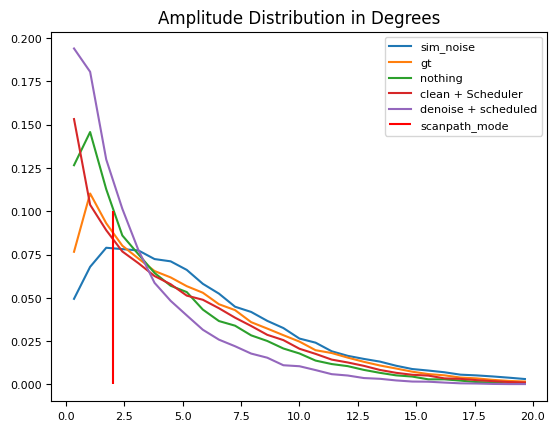

In [23]:
from src.eval.eval_utils import plot_amplitude_dist, plot_angle_distribution, plot_autocorrelation, plot_consecutive_angles, plot_vector_dist, calculate_relative_vectors                        
plot_amplitude_dist([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list],
                    [gaze[2] for gaze in gaze_list])

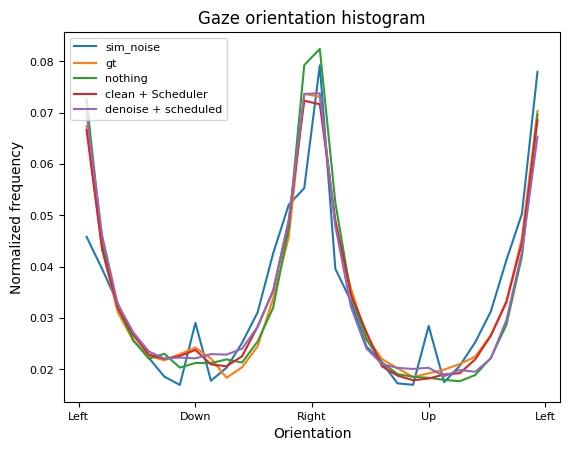

In [24]:
plot_angle_distribution([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list])
plt.show()

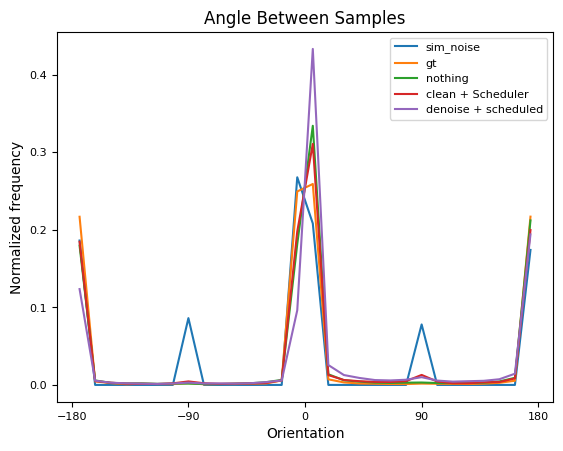

In [25]:
plot_consecutive_angles([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list])
plt.show()

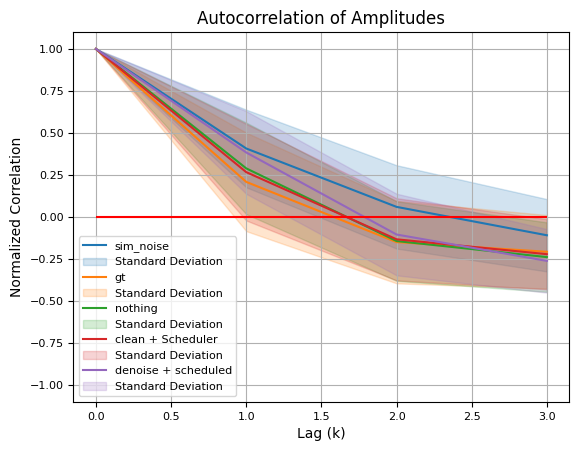

In [26]:
plot_autocorrelation([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list], min_len=4)
plt.show()

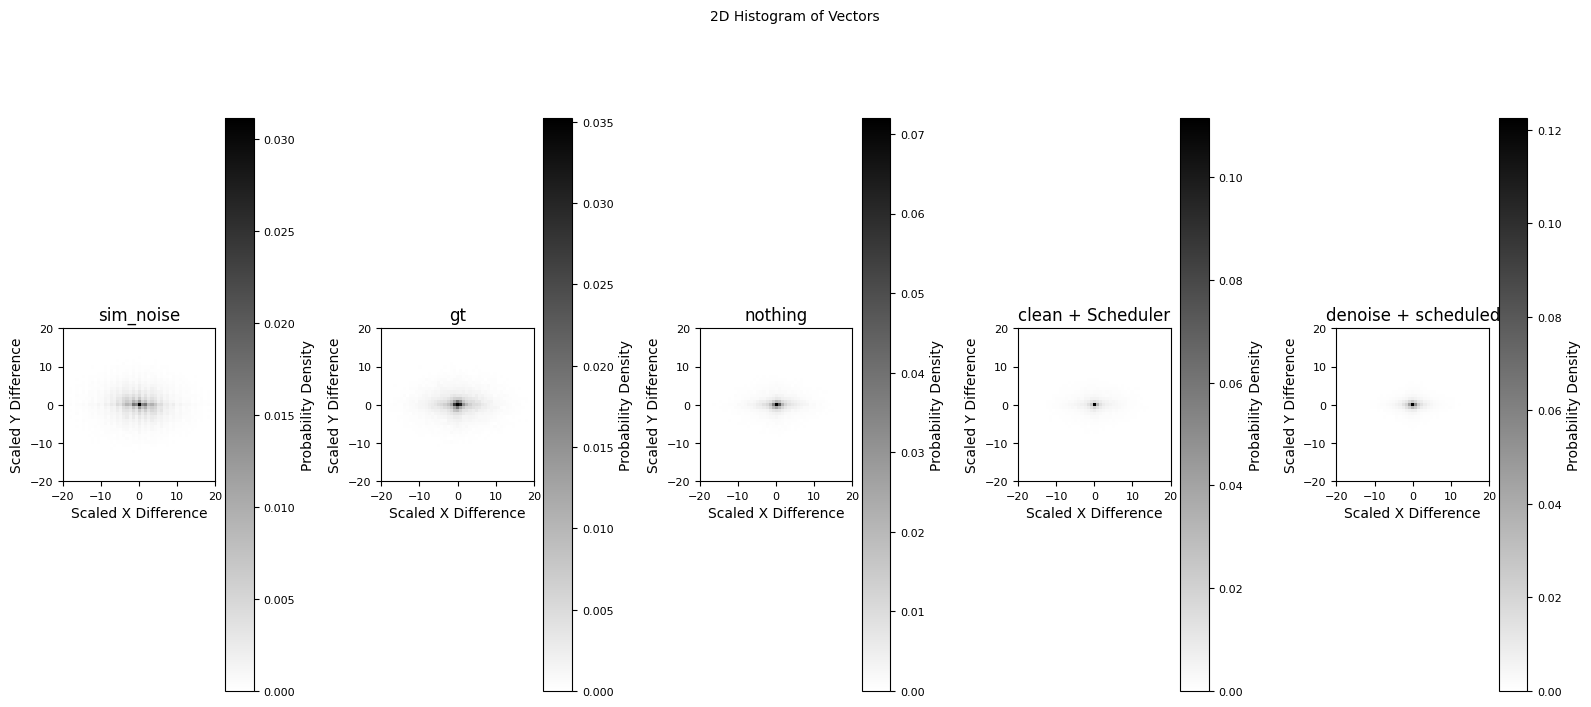

In [27]:
plot_vector_dist([[np.diff(gaze_sample[:2, :], axis=1) for gaze_sample in gaze[0]] for gaze in gaze_list],
                 [gaze[2] for gaze in gaze_list], 
                 [gaze[1] for gaze in gaze_list],)

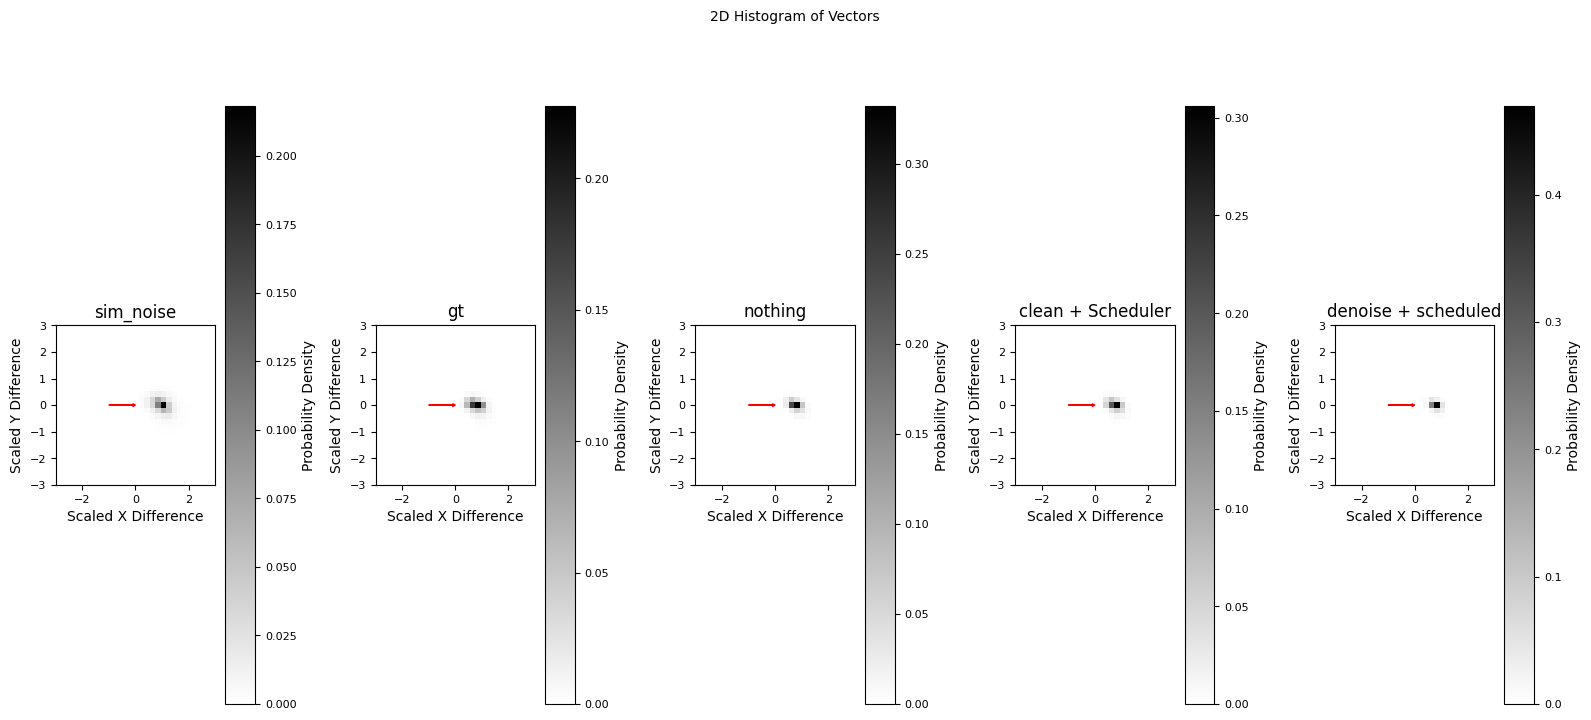

In [28]:
plot_vector_dist([[calculate_relative_vectors(gaze_sample) for gaze_sample in gaze[0]] for gaze in gaze_list],
                    [1 for _ in gaze_list],
                    [gaze[1] for gaze in gaze_list],-3,3,30, arrow= True)

plt.show()